In [2]:
import pandas as pd
import numpy as np
population_df = pd.read_csv("../data/synthetic_population.csv")

In [3]:
def initialize_individual_risks(df):
    """
    Maps demographic features to individual SEIR parameters.
    """ 
    df = df.copy()

    df["transmission_multiplier"] = 1.0

    df['transmission_multiplier'] = np.where(df['frontline_worker'] == 1, df['transmission_multiplier'] * 1.8, df['transmission_multiplier'])

    df['transmission_multiplier'] = np.where(df['multigenerational'] == 1, df['transmission_multiplier'] * 1.3, df['transmission_multiplier'])


    # SES Quintile
    ses_map = {1: 1.5, 2: 1.3, 3: 1.1, 4: 1.0, 5: 0.8}
    df['transmission_multiplier'] *= df['ses_quintile'].map(ses_map).fillna(1.0)

    # Mortality Risk
    # Risk increases exponentially with age
    # Base age 25, doubling risk every ~8 years
    df['age_factor'] = np.exp(0.09 * (df['age'] - 25))

    # Comorbidity Odds Ratio (estimated from CDC/NIH data)
    comorbidity_weights = {
        'has_diabetes': 1.9,
        'has_hypertension': 1.5,
        'has_heart_disease': 2.1,
        'has_copd_or_chronic_resp_disease': 2.0,
        'has_obesity': 1.6,
        'is_long_term_care': 5.0  # Huge risk factor
    }

    df['comorbidity_multiplier'] = 1.0
    for feature, weight in comorbidity_weights.items():
        df.loc[df[feature] == 1, 'comorbidity_multiplier'] *= weight
    

    # Final individual mortality Probability
    base_ifr = 0.005 #0.5% baseline
    df['individual_mortality_prob'] = base_ifr * df['age_factor'] * df['comorbidity_multiplier']

    # Clip probabilities at 1.0
    df['individual_mortality_prob'] = df['individual_mortality_prob'].clip(0, 1)

    return df

def run_agent_based_seir(df, days=100, initial_infected=10, base_beta=0.3):
    N = len(df)
    states = np.zeros(N) # 0:S, 1:E, 2:I, 3:R, 4:D
    
    # Seed infections
    states[np.random.choice(N, initial_infected, replace=False)] = 2
    
    # Pre-extract probabilities as arrays for speed
    trans_mult = df['transmission_multiplier'].values
    death_probs = df['individual_mortality_prob'].values
    
    sigma = 1/5.2  # E -> I rate
    gamma = 1/10.0 # I -> R/D rate
    history = []

    for t in range(days):
        infected_mask = (states == 2)
        n_infected = np.sum(infected_mask)
        
        history.append({'S': np.sum(states==0), 'E': np.sum(states==1), 
                        'I': n_infected, 'R': np.sum(states==3), 'D': np.sum(states==4)})

        if n_infected == 0: break

        # Calculate current infection risk for everyone
        force_of_infection = base_beta * (n_infected / N)
        
        # 1. Transitions: S -> E
        s_mask = (states == 0)
        # Everyone rolls the dice at once
        infect_roll = np.random.rand(N) < (force_of_infection * trans_mult)
        states[s_mask & infect_roll] = 1
        
        # 2. Transitions: E -> I
        e_mask = (states == 1)
        exposed_roll = np.random.rand(N) < sigma
        states[e_mask & exposed_roll] = 2
        
        # 3. Transitions: I -> R or D
        # Only check people who are currently infected and ready to "resolve"
        resolve_roll = np.random.rand(N) < gamma
        to_resolve = infected_mask & resolve_roll
        
        if np.any(to_resolve):
            # For those resolving, roll for death vs recovery
            death_roll = np.random.rand(N) < death_probs
            states[to_resolve & death_roll] = 4 # Dead
            states[to_resolve & ~death_roll] = 3 # Recovered

    return pd.DataFrame(history), states

In [4]:
# Execution
population_df = initialize_individual_risks(population_df)
sim_history, final_states = run_agent_based_seir(population_df)

In [5]:
# summary of who died
population_df['is_dead'] = (final_states == 4).astype(int)

# Insight A: Mortality by Age
age_impact = population_df.groupby(pd.cut(population_df['age'], [0, 50, 65, 80, 110]))['is_dead'].mean()

# Insight B: Infection by Occupation
# (We need to see who entered the 'E', 'I', 'R', or 'D' states)
population_df['was_infected'] = (final_states > 0).astype(int)
job_impact = population_df.groupby('frontline_worker')['was_infected'].mean()

print(f"Mortality by Age:\n{age_impact}")
print(f"Infection Rate (Frontline vs Not):\n{job_impact}")

Mortality by Age:
age
(0, 50]      0.017908
(50, 65]     0.153462
(65, 80]     0.712407
(80, 110]    0.956408
Name: is_dead, dtype: float64
Infection Rate (Frontline vs Not):
frontline_worker
0    0.959877
1    0.996320
Name: was_infected, dtype: float64


C:\Users\vinee\AppData\Local\Temp\ipykernel_26980\244251261.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_impact = population_df.groupby(pd.cut(population_df['age'], [0, 50, 65, 80, 110]))['is_dead'].mean()


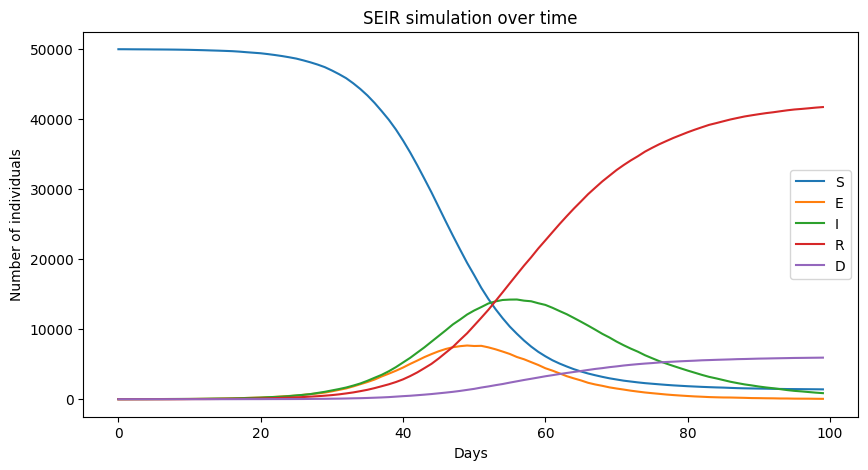

In [6]:
import matplotlib.pyplot as plt 

sim_history.plot(figsize=(10,5))
plt.title("SEIR simulation over time")
plt.xlabel("Days")
plt.ylabel("Number of individuals")
plt.show()

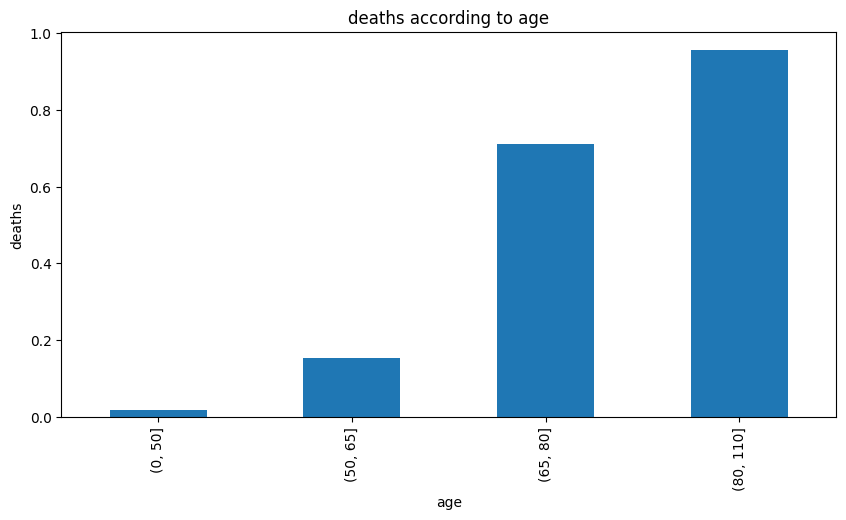

In [ ]:
age_impact.plot(kind = "bar", figsize=(10,5))
plt.title("deaths according to age")
plt.xlabel("age")
plt.ylabel("deaths")
plt.show()

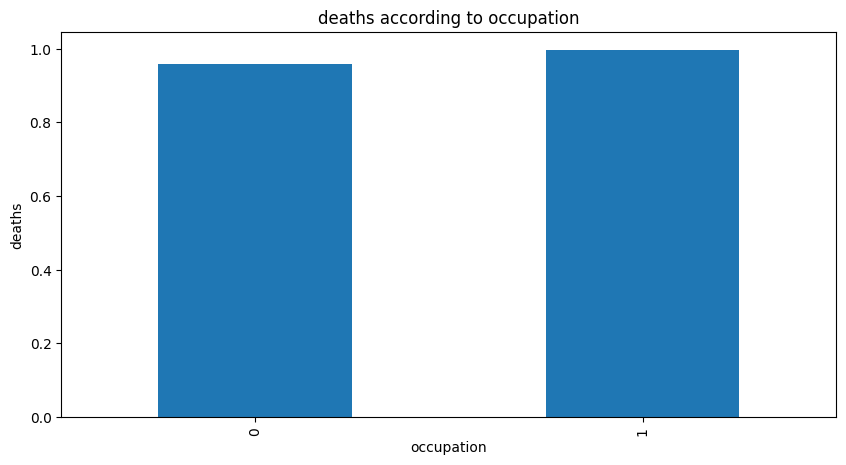

In [10]:
job_impact.plot(kind = "bar", figsize=(10,5))
plt.title("deaths according to occupation")
plt.xlabel("occupation")
plt.ylabel("deaths")
plt.show()

### Biased rollouts

In [ ]:
def apply_biased_rollout(df, capacity_percent = 0.2):
    """
    Assigning vaccines based on the historical policy.
    we vaccinate 20% of the population.
    """
    df = df.copy()

    # priority score based on the following features:
    # 1. Age
    # 2. Frontline status
    # 3. SES bias: 5 has better access to vaccines
    df['priority_score'] = (
        (df['age'] / 100) * 10 +
        (df['frontline_worker'] * 5) +
        (df['ses_quintile'] * 0.5) +
        np.random.normal(0, 1, len(df))
    )
    
    # vaccinating the top N people based on available capacity
    num_to_vax = int(len(df) * capacity_percent)
    threshold = df['priority_score'].nlargest(num_to_vax).min()

    df['is_vaccinated'] = (df['priority_score'] >= threshold).astype(int)

    return df

In [12]:
# updating the SEIR model with vaccination logic

def run_agent_based_seir_with_vax(df, days = 100, base_beta =0.3):
    df = df.copy()
    N = len(df)
    states = np.zeros(N)
    states[np.random.choice(N, 10, replace = False)] = 2 # 10 Infections

    ve_inf = 0.70 # assumption that 70% reduction in getting infected
    ve_mort = 0.95 # assumption that 95% reduction in death if infected

    history = []
    for t in range(days):
        infected_mask = (states == 2)
        n_infected = np.sum(infected_mask)
        history.append({'S': (states ==0).sum(), 'I': n_infected, 'D': (states == 4).sum()})
        if n_infected == 0: break

        force_of_infection = base_beta * (n_infected / N)

        # 1. S -> E ()
        s_mask = (states == 0)

        current_trans_risk = df['transmission_multiplier'].values * force_of_infection
        current_trans_risk = np.where(df['is_vaccinated'] == 1, current_trans_risk * (1 - ve_inf), current_trans_risk)

        states[s_mask & (np.random.rand(N) < current_trans_risk)] = 1

        # 2. E -> I
        states[(states == 1) & (np.random.rand(N) < 1/5.2)] = 2

        # 3. I -> R
        resolve_mask = (states == 2) & (np.random.rand(N) < 1/10.0)
        if resolve_mask.any():
            current_mort_risk = df['individual_mortality_prob'].values
            # apply vaccine reduction to mortality risk
            current_mort_risk = np.where(df['is_vaccinated'] == 1, current_mort_risk * (1 - ve_mort), current_mort_risk)


            death_event = np.random.rand(N) < current_mort_risk
            states[resolve_mask & death_event] = 4
            states[resolve_mask & ~death_event] = 3
    
    return pd.DataFrame(history), states



In [13]:
# assigning vaccines
intervened_df = apply_biased_rollout(population_df, capacity_percent=0.25)

# simulation
vax_sim_history, vax_final_states = run_agent_based_seir_with_vax(intervened_df)

# comparison of the two
total_deaths_baseline = (final_states == 4).sum()
total_deaths_vax = (vax_final_states == 4).sum()
lives_saved = total_deaths_baseline - total_deaths_vax

print(f"total deaths in baseline: {total_deaths_baseline}")
print(f"total deaths in intervention: {total_deaths_vax}")
print(f"lives saved: {lives_saved}")

total deaths in baseline: 5949
total deaths in intervention: 2052
lives saved: 3897


### Calculating propensity scores using logistic regression

In [14]:
from sklearn.linear_model import LogisticRegression

def estimate_propensity_scores(df):
    # these features influenced the treatment assignment
    features = ['age', 'frontline_worker', 'ses_quintile']
    X = df[features]
    A = df['is_vaccinated']

    # fit the model
    lr = LogisticRegression()
    lr.fit(X, A)

    # probability of being vaccinated 
    df['propensity_score'] = lr.predict_proba(X)[:, 1]

    return df

intervened_df = estimate_propensity_scores(intervened_df)

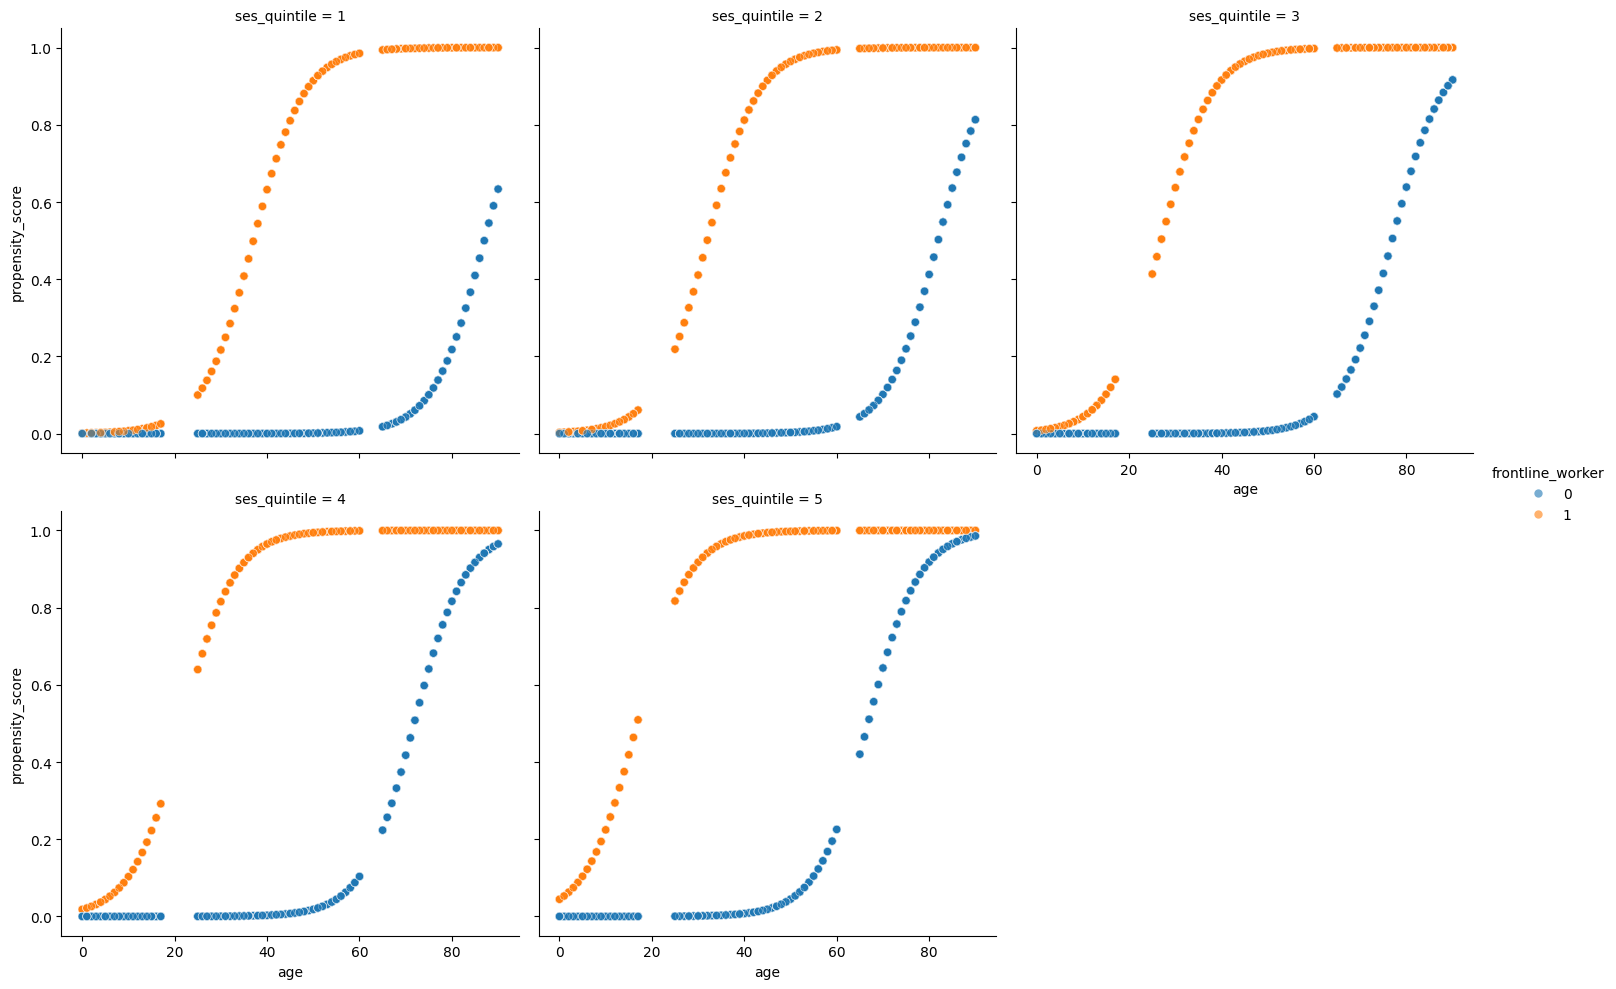

In [16]:
import seaborn as sns
sns.relplot(
    data = intervened_df,
    x='age', y='propensity_score',
    col = 'ses_quintile',
    hue= 'frontline_worker',
    kind= 'scatter',
    col_wrap = 3,
    alpha = 0.6
)

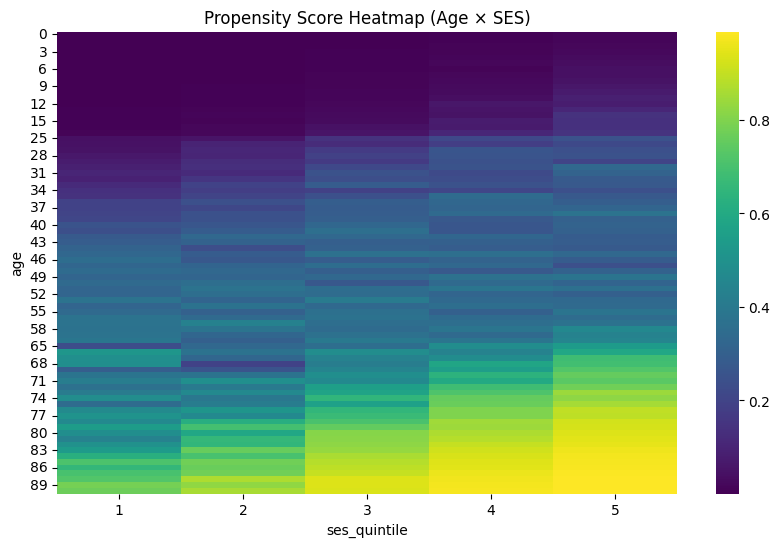

In [19]:
pivot = intervened_df.pivot_table(
    values='propensity_score',
    index='age',
    columns='ses_quintile',
    aggfunc='mean'
)

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap='viridis')
plt.title("Propensity Score Heatmap (Age × SES)")
plt.show()